# Load Data

I have included two data sets.  One is a data set generated from a simulation of our algorithm and another from running the algorithm on a real quantum device.  

In [147]:
Load = 'Quantum'
#Load = 'Simulation'

## Parameter set used to save and load the data

In [148]:
#Parameters
u=4.0
t=-1
beta = 0.201
A = 10
a = 0.05
gamma = 0.101
c = 0.4
beta_a = 0.201
A_a = 10
a_a = 0.05
gamma_a = 0.101
c_a = 0.4
T=2

## Load the data

The file we are loading contains information about each iteration of the algorithm.  We will be interested specfically in the final iteration.

In [149]:
import pickle

if Load == 'Simulation':
    file_to_read = open("VQE_Gunlycke_2_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "rb")
if Load == 'Quantum':
    file_to_read = open("VQE_jakarta_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "rb")


loaded_object = pickle.load(file_to_read)

In [150]:
file_to_read

<_io.BufferedReader name='VQE_jakarta_T2_A_10_a_0.05_c_0.4_beta_0.201_gamma_0.101_t_-1_u_4.0.pickle'>

## Plot the energy of each iteration

Just for reference this is how the energy looks during the algorithm.  

Text(0, 0.5, 'Energy')

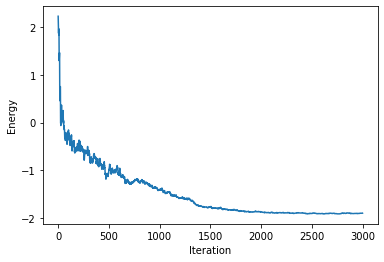

In [138]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.xlabel("Iteration")
plt.ylabel("Energy")

## Get the final rotation angles and weights

The structure of the angles is $\phi_{S,T,Q}$ where the first index $S$ runs over the sections of the wave function, the second $T$ runs over the sequential applications of the bare ansatz, here we run the bare ansatz twice, and the final index $Q$ runs over the qubits.

The structure of the weights is $\alpha_S$ where the only index is $S$ which runs over the sections of the wave function.  These act as weights for each section of the wavefunction generated by $\phi_{S,\ldots}$

In [139]:
final_iteration = len(loaded_object)-1
phi = loaded_object[final_iteration]['phi']  #Rotation angles
alpha = loaded_object[final_iteration]['alpha']  #Weights

## Reconstructing the circuits

In [140]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute

Q = 3
# A single instance of the bare ansatz
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i
# The full ansatz
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir
# Needed to connect different sections of the wavefunction
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i
# The full off diagonal ansatz
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

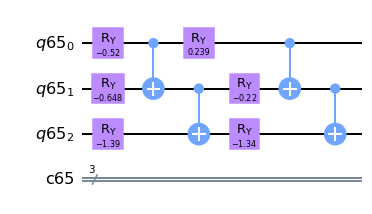

In [141]:
#Example of a circuit for a section S.   
S = 1
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,phi[S])

tst.draw(output = 'mpl')

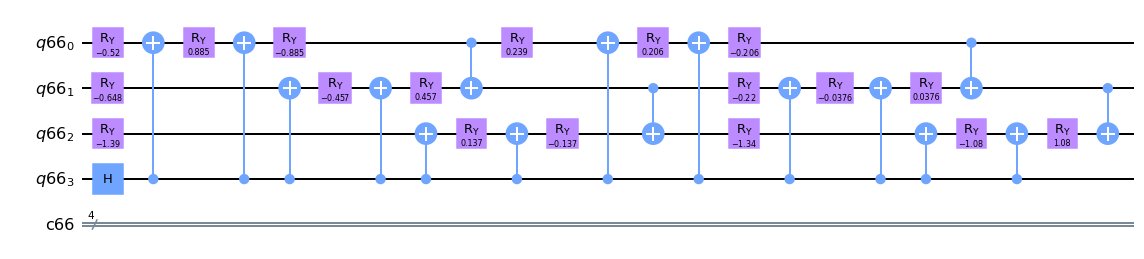

In [142]:
#Example of a sercet which connects two sections S1 and S2
S1 = 1
S2 = 4
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,phi[S1],phi[S2])

tst.draw(output = 'mpl')

## Calculating the energy

First we need to load the list of Pauli strings which define the Hamiltonian.  The Hamiltonian is divided into blocks which act on the sections of the wavefunction.  Each block contains a list of Pauli strings which defines the part of the Hamiltonain which lives in that block.  

In [143]:
import pickle

file_to_read = open("Blocks_t_"+str(t)+"_u_"+str(u)+".pickle", "rb")

loaded_blocks = pickle.load(file_to_read)

In [146]:
file_to_read

<_io.BufferedReader name='Blocks_t_-1_u_4.0.pickle'>

In [144]:
E0 = -2.1027484834620758 #The target ground state energy
blocks = loaded_blocks

The structure of the blocks is $H_{S1,S2,P}$ where $S1$ and $S2$ define sections of the wavefunction and $P$ runs of the set of Pauli strings the define the Hamiltoniain in the block defined by $S1$ and $S2$.  Each Pauli string also comes with a coeficient which tells you how much it contributes to the total energy.

In [145]:
#An example of a Pauli string held used for calculating the energy
S1 = 0
S2 = 1
P = 3
blocks[str(S1)+','+str(S2)][P]

{'coef': 0.25, 'pauli': 'ZZI'}

The total energy is given by
$$ E = \sum_{S1,S2} <\psi_{S1}|\sum_p H_{S1,S2,P}|\psi_{S1}> $$
where $ |\psi_{S}> $ is the state generated by the circuit using the angles $\phi_{S,T,Q}$ for all $T$ and $Q$.


In [105]:
import copy 
from qiskit import quantum_info as qi
import numpy as np

#Measure a puali string given a circuit
def measure_pauli(p_label,psi0):
    wave0 = qi.Statevector.from_instruction(psi0)
    Op = qi.Operator.from_label(p_label)
    return np.dot(np.conjugate(wave0),np.dot(Op,wave0))

#Calculate the energy for a block that connects the same section of the wavefunction (on-diagonal) 
def E_on_block(phi_b,block):
    E = 0
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p['coef']
        p_label = p['pauli']
        E_p = measure_pauli( p_label,psi)
        E += w*E_p
    return E

#Calculate the energy for a block that connects different sections of the wavefunction (off-diagonal)
def E_off_block(phi_a,phi_b,block):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p['coef']
        p_label = p['pauli']
        E_p = measure_pauli('X' + p_label,psi)
        E += w*E_p
    return E

#Find the total energy summing over all blocks
def find_E(alpha,phi,blocks):
    E = 0
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            E += alpha[int(key[0])]*alpha[int(key[2])]*E_on_block(phi[int(key[0])],blocks[key])
        else:
            E += 2*alpha[int(key[0])]*alpha[int(key[2])]*E_off_block(phi[int(key[0])],phi[int(key[2])],blocks[key])
    return E
            

In [106]:
find_E(alpha,phi,blocks)

(0.01801680528778638+0j)